# Project: Crime Rate Prediction
**Name:** Wahid Hashem, Aryan Sharma, Zewen Wang
**Date:** 12/5/2025
**Course:** STT 810

### Description
This project analyzes the "Communities and Crime" dataset from UCI repository. It uses Principal Component Analysis (PCA) to reduce 100+ features into key components and compares the performance of Linear Regression vs. Logistic Regression in predicting high-crime areas.

### Complex Aspects Demonstrated
1. **Feature Engineering:** Created a binary target variable from continuous crime data.
2. **Hyperparameter Tuning:** Automated selection of PCA components based on variance thresholds.
3. **Model Comparison:** Evaluated Linear vs. Logistic regression performance on reduced feature sets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# Load Data
X_normalized = pd.read_csv("crime_normalized_features.csv")
Y_normalized = pd.read_csv("crime_normalized_targets.csv")

# Clean Data (Replace "?" with NaN)
X_normalized = X_normalized.replace("?", np.nan)

# Convert to Numeric
X = X_normalized.apply(pd.to_numeric, errors="coerce")
Y = Y_normalized['ViolentCrimesPerPop'] # already numeric

# Drop Features with many Missing Values (>85%)
X = X.dropna(axis = 1)

# Drop Metadata Columns (Useless for PCA)
drop_cols = ['state', 'county', 'community', 'communityname', 'fold']
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")

print(f"Data shape after cleaning: {X.shape}")

Data shape after cleaning: (1994, 99)


In [3]:
# PCA Analysis
pca = PCA()
X_pca = pca.fit_transform(X)

# Variance Explained
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


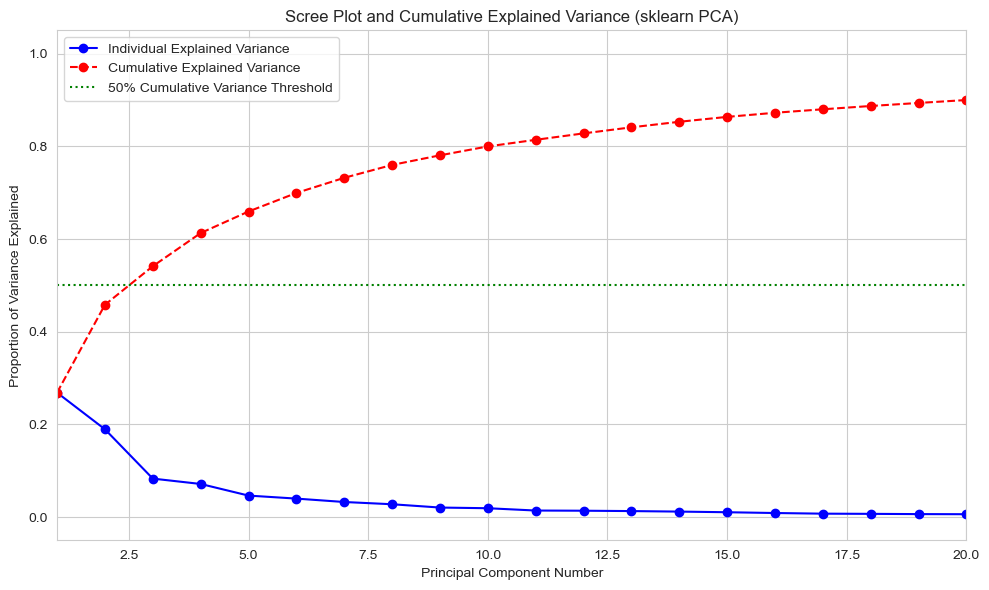

In [4]:
# Scree Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

components = range(1, len(explained_variance) + 1)
plt.plot(
    components,
    explained_variance,
    marker="o",
    linestyle="-",
    color="b",
    label="Individual Explained Variance",
)
plt.plot(
    components,
    cumulative_variance,
    marker="o",
    linestyle="--",
    color="r",
    label="Cumulative Explained Variance",
)
plt.axhline(y=0.50, color="g", linestyle=":", label="50% Cumulative Variance Threshold") # 50% Threshold

plt.title("Scree Plot and Cumulative Explained Variance (sklearn PCA)")
plt.xlabel("Principal Component Number")
plt.ylabel("Proportion of Variance Explained")
plt.legend()
plt.grid(True)
plt.xlim(1, 20)
plt.tight_layout()
plt.show()


Top 10 Features Driving PC1 and PC2:
            Feature  Strength  PC1_Loading  PC2_Loading
       PctRecImmig8  0.255825    -0.006481     0.255743
      PctRecImmig10  0.254200    -0.003869     0.254171
       PctRecImmig5  0.253304    -0.003422     0.253281
     PctRecentImmig  0.249099    -0.006043     0.249026
     PctForeignBorn  0.243416    -0.029213     0.241657
           pctUrban  0.236136    -0.152898     0.179951
          RentHighQ  0.233461    -0.193379     0.130799
   PctSpeakEnglOnly  0.217830    -0.021832    -0.216733
PctNotSpeakEnglWell  0.214605     0.045832     0.209654
       OwnOccMedVal  0.210410    -0.164471     0.131232


<positron-console-cell-11>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



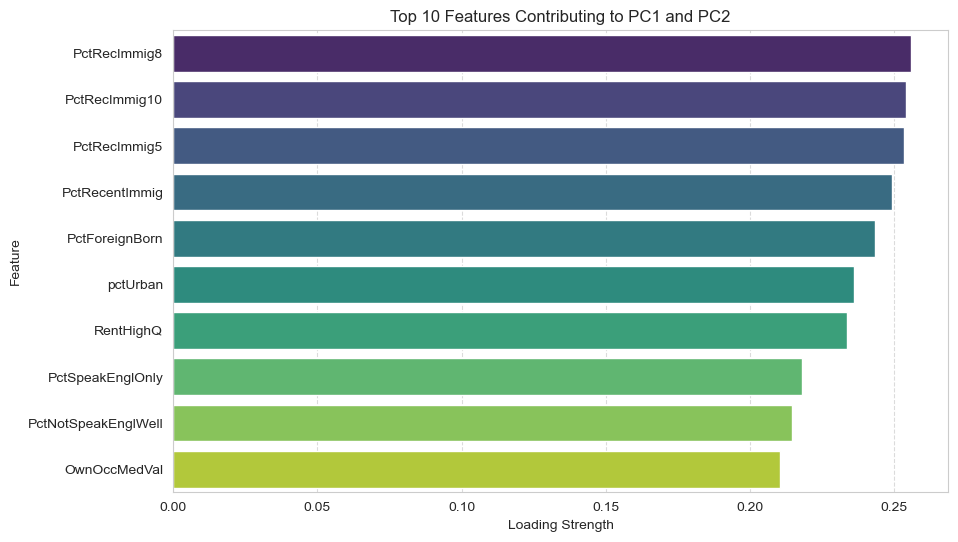

In [ ]:
# pca.components_ has shape (n_components, n_features)
loadings = pca.components_.T
# We only care about the first two components for this analysis
loadings_pc1_pc2 = loadings[:, :2]

# Magnitude = sqrt(PC1^2 + PC2^2)
magnitudes = np.sqrt(loadings_pc1_pc2[:, 0] ** 2 + loadings_pc1_pc2[:, 1] ** 2)

features_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "PC1_Loading": loadings_pc1_pc2[:, 0],
        "PC2_Loading": loadings_pc1_pc2[:, 1],
        "Strength": magnitudes,
    }
)

top_10 = features_df.sort_values(by="Strength", ascending=False).head(10)
print("Top 10 Features Driving PC1 and PC2:")
print(
    top_10[["Feature", "Strength", "PC1_Loading", "PC2_Loading"]].to_string(index=False)
)

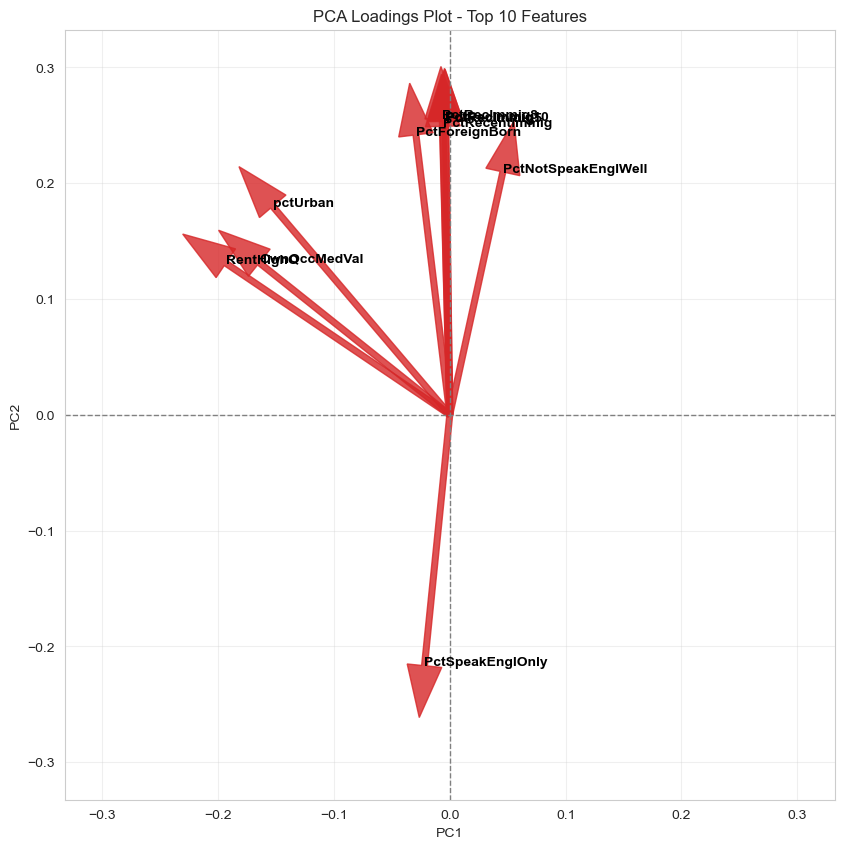

In [ ]:
# Loading Plot

plt.figure(figsize=(10, 10))

# 1. Setup the plot axis (Center at 0,0)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)

# 2. Draw Arrows and Collect Labels
texts = []
for i, row in top_10.iterrows():
    # Draw the arrow
    plt.arrow(0, 0, row['PC1_Loading'], row['PC2_Loading'], 
              color='tab:red', alpha=0.8, width=0.005, head_width=0.03)
    
    # Create the text label (we will adjust its position later)
    texts.append(plt.text(row['PC1_Loading'], row['PC2_Loading'], 
                          row['Feature'], fontsize=10, color='black', weight='bold'))

# 3. Add a Circle (Optional, represents max correlation of 1.0)
circle = plt.Circle((0, 0), 0.5, color='blue', fill=False, linestyle=':', alpha=0.3)
plt.gca().add_artist(circle)

# 5. Final Formatting
# Set limits slightly larger than the largest vector
max_limit = top_10[['PC1_Loading', 'PC2_Loading']].abs().max().max() * 1.3
plt.xlim(-max_limit, max_limit)
plt.ylim(-max_limit, max_limit)

plt.xlabel(f"PC1")
plt.ylabel(f"PC2")
plt.title("PCA Loadings Plot - Top 10 Features")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal') # Keeps the arrows proportional
plt.show()

In [6]:
# Linear Regression Model
print("\n--- Linear Regression ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Pipeline
pipe_linear = Pipeline([
    ('pca', PCA(n_components=3)), 
    ('lin_reg', LinearRegression())
])

# Fit & Predict
pipe_linear.fit(X_train, y_train)
y_pred = pipe_linear.predict(X_test)


# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


--- Linear Regression ---
MSE: 0.0241
R2 Score: 0.4961


In [7]:
# Linear Regression Model (MSE/R2 Analysis)
print("\n--- Linear Regression Analysis ---")

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 2. Pipeline
pipe_linear = Pipeline([
    ('pca', PCA(n_components=3)), 
    ('lin_reg', LinearRegression())
])

# 3. Fit & Predict
pipe_linear.fit(X_train, y_train)
y_pred = pipe_linear.predict(X_test)

# 4. Scores
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


--- Linear Regression Analysis ---
MSE: 0.0241
R2 Score: 0.4961



--- Final Model Comparison (3 PCs) ---
Linear Regression (Thresholded) Accuracy: 0.7569
Logistic Regression Accuracy:             0.7995

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       224
           1       0.77      0.77      0.77       175

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399



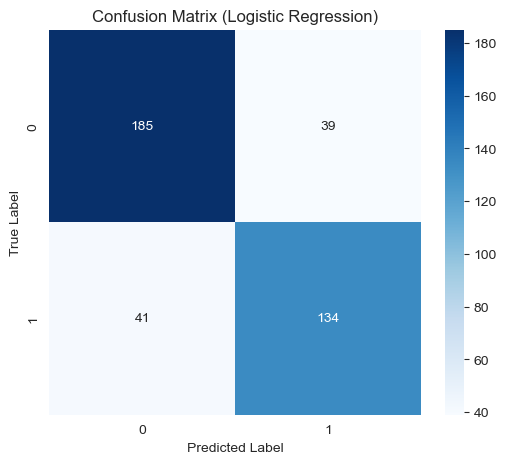

In [8]:
# Model Comparison
print("\n--- Final Model Comparison (3 PCs) ---")

# 1. Prepare Targets
threshold = Y.median()

# 2. Split Data (Continuous Targets)
# We split X and Y (continuous) to support both models
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Create Binary Targets for Logistic Regression
y_train_bin = (y_train_cont > threshold).astype(int)
y_test_bin = (y_test_cont > threshold).astype(int)

# --- Model 1: Linear Regression (Thresholded) ---
pipe_linear = Pipeline([
    ('pca', PCA(n_components=3)),       
    ('lin_reg', LinearRegression())
])
pipe_linear.fit(X_train, y_train_cont) 
y_pred_cont = pipe_linear.predict(X_test)
y_pred_linear_bin = (y_pred_cont > threshold).astype(int) 
acc_linear = accuracy_score(y_test_bin, y_pred_linear_bin)

# --- Model 2: Logistic Regression (Classifier) ---
pipe_logistic = Pipeline([
    ('pca', PCA(n_components=3)),      
    ('log_reg', LogisticRegression())
])
pipe_logistic.fit(X_train, y_train_bin) 
y_pred_log = pipe_logistic.predict(X_test)
acc_logistic = accuracy_score(y_test_bin, y_pred_log)

# --- Output ---
print(f"Linear Regression (Thresholded) Accuracy: {acc_linear:.4f}")
print(f"Logistic Regression Accuracy:             {acc_logistic:.4f}")

# Classification Report (Moved from deleted cell)
print("\n--- Logistic Regression Report ---")
print(classification_report(y_test_bin, y_pred_log))

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_log)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

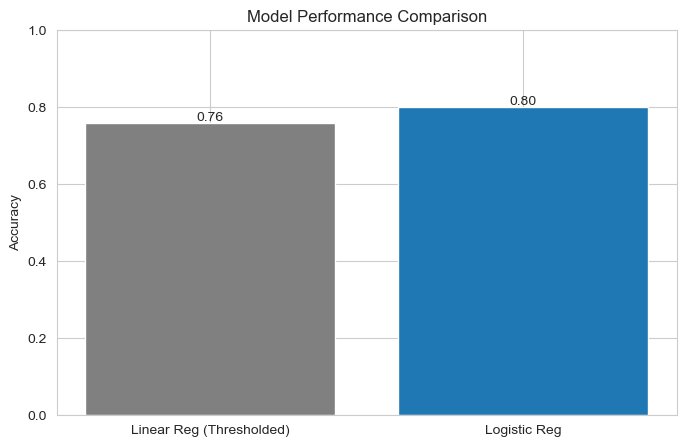

In [9]:
# Model Comparison Bar Chart
models = ['Linear Reg (Thresholded)', 'Logistic Reg']
accuracies = [acc_linear, acc_logistic]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['gray', '#1f77b4'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.bar_label(bars, fmt='%.2f')
plt.show()

### References
1. **Dataset:** Communities and Crime Dataset (UCI Machine Learning Repository).
2. **Libraries:** Scikit-learn, Pandas, NumPy, Seaborn.